In [1]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

In [2]:
import cnn_utils as utils
from model_evaluation_utils import get_metrics

In [3]:
# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from tensorflow.keras.models import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

In [5]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  stratify=np.array(y_train),
                                                  random_state=42)

In [8]:
Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

In [9]:
#!python -m pip install -U scikit-image
from skimage.transform import resize

X_train = np.array([resize(x, (48, 48)) for x in X_train])
X_val = np.array([resize(x, (48, 48)) for x in X_val])
X_test = np.array([resize(x, (48, 48)) for x in X_test])

In [10]:
base_model = vgg.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(48, 48, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [11]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [12]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [13]:
for layer in base_model.layers:
     layer.trainable = False

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [16]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [17]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train,
                                     batch_size=BATCH_SIZE)

In [18]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [19]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/40
1328/1328 [==============================] - 20s 10ms/step - loss: 0.2351 - accuracy: 0.4707 - val_loss: 0.1898 - val_accuracy: 0.5739
Epoch 2/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.1961 - accuracy: 0.5683 - val_loss: 0.1780 - val_accuracy: 0.6042
Epoch 3/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.1845 - accuracy: 0.5976 - val_loss: 0.1689 - val_accuracy: 0.6274
Epoch 4/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.1760 - accuracy: 0.6171 - val_loss: 0.1649 - val_accuracy: 0.6418
Epoch 5/40
1328/1328 [==============================] - 14s 10ms/step - loss: 0.1700 - accuracy: 0.6337 - val_loss: 0.1612 - val_accuracy: 0.6429
Epoch 6/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.1651 - accuracy: 0.6475 - val_loss: 0.1575 - val_accuracy: 0.6545
Epoch 7/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.1608 - accuracy: 0.6561 - val_loss: 0.1565 - val_

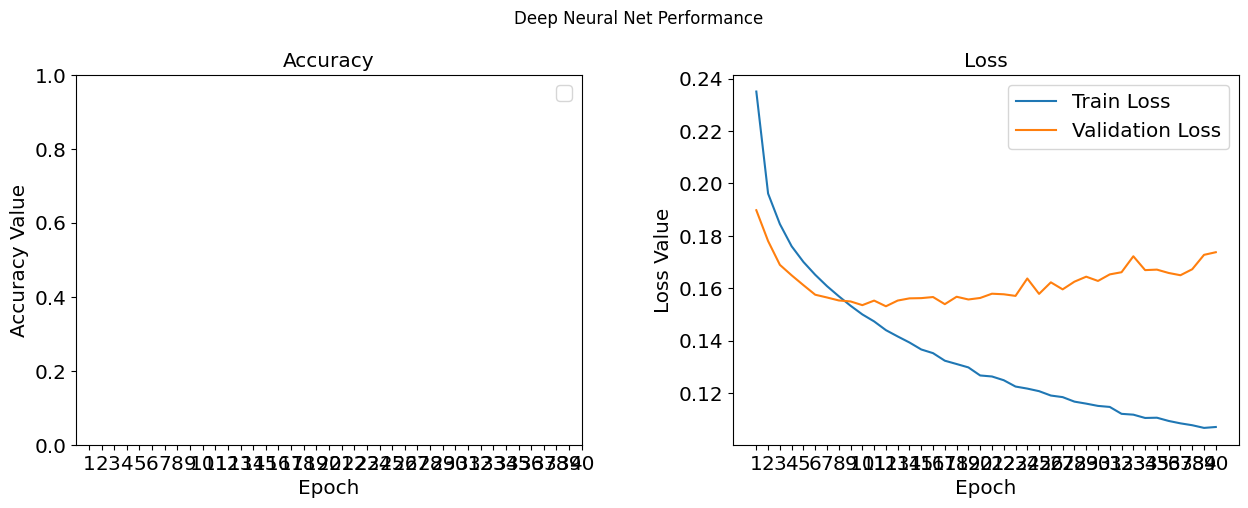

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
# ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
# ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [23]:
predictions = model.predict(X_test/255.)

313/313 [==============================] - 2s 6ms/step


In [24]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [25]:
get_metrics(true_labels=y_test,
                predicted_labels=predictions)

Accuracy: 0.6761
Precision: 0.6835
Recall: 0.6761
F1 Score: 0.678


In [26]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

In [28]:
# utils.plot_predictions(model=model,dataset=X_test/255.,
#                        dataset_labels=Y_test,
#                        label_dict=label_dict,
#                        batch_size=16,
#                        grid_height=4,
#                        grid_width=4)